In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter
from unified_model import unified
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel



In [3]:
# Magnet Assembly
magnet_assembly = mechanical_components.MagnetAssembly(
    m=2,
    l_m_mm=10,
    l_mcd_mm=24,
    dia_magnet_mm=10,
    dia_spacer_mm=10
)

In [20]:
# Damper
b_m1, b_m2 = (5.742857, 0.003333)

damper = mechanical_components.damper.QuasiKarnoppDamper(
    coulomb_damping_coefficient=b_m1,
    motional_damping_coefficient=b_m2,
    magnet_assembly=magnet_assembly,
    tube_inner_radius_mm=5.5 
)

In [21]:
damper.get_force(0.001)

0.00011366804657794413

In [7]:
# Top collision
mech_spring = mechanical_components.MechanicalSpring(
    magnet_assembly=magnet_assembly,
    position=150/1000,  # position of the microgenerator "top" (in metres)
    damping_coefficient=10  # Controls how "lossy" the impact is.
) 

mech_spring

MechanicalSpring(position=0.15, magnet_length=0.01, magnet_assembly_length=0.034, strength=10000000.0, damping_coefficient=10)

In [8]:
# Magnetic spring
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=10 / 1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

In [9]:
# Electrical components
# Load
load = electrical_components.SimpleLoad(R=30)

# Rectifier loss
v_rect_drop = 0.1

In [10]:
# Params
c = 1
n_z = 88
n_w = 20

# Coupling model
coupling = CouplingModel().set_coupling_constant(4.1667)

# Coil
coil_config = electrical_components.coil.CoilConfiguration(
    c=c,
    n_z=n_z,
    n_w=n_w,
    l_ccd_mm=0,
    ohm_per_mm=1079/1000/1000,
    tube_wall_thickness_mm=1,
    coil_wire_radius_mm=0.143 / 2,
    coil_center_mm=91 - 13,  # Must be relative to *top* of fixed magnet
    inner_tube_radius_mm=5.5
)

In [11]:
import numpy as np
from flux_modeller.model import CurveModel

curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model.model')
# Predict the flux curve
X = np.array([[n_z, n_w]]).reshape(1, -1)
x_curve, phi_curve = curve_model.predict_curves(X)

# flux model
flux_model = electrical_components.FluxModelInterp(
    coil_config=coil_config,
    magnet_assembly=magnet_assembly
)

flux_model.fit(x_curve, phi_curve.reshape(-1))  # Fit flux curve

In [22]:
# Get our input excitation and groundtruth data
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from unified_model.gridsearch import AccelerometerInputsFactory
from unified_model.evaluate import GroundTruthFactory

from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any

# Prepare data
samples_list = collect_samples(base_path='../data/2021-03-05/',
                               acc_pattern='D/*acc*.csv',
                               adc_pattern='D/*adc*.csv',
                               video_label_pattern='D/*labels*.csv')

groundtruth_factory = GroundTruthFactory(samples_list,
                                        lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                        seconds_per_frame=1/60,
                                                        pixel_scale=0.154508),
                                        adc_kwargs=dict(voltage_division_ratio=1 / 0.342))
accelerometer_factory = AccelerometerInputsFactory(samples_list)
groundtruth = groundtruth_factory.make()
input_excitations = accelerometer_factory.make()

In [23]:
# Build the unified model
from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import UnifiedModel
from unified_model import pipeline
from unified_model import governing_equations

mechanical_model = MechanicalModel() \
    .set_damper(damper) \
    .set_magnet_assembly(magnet_assembly) \
    .set_magnetic_spring(magnetic_spring) \
    .set_mechanical_spring(mech_spring) \

electrical_model = ElectricalModel() \
    .set_rectification_drop(v_rect_drop) \
    .set_load_model(load) \
    .set_flux_model(flux_model.flux_model, flux_model.dflux_model) \
    .set_coil_configuration(coil_config)

unified_model = UnifiedModel() \
    .set_mechanical_model(mechanical_model) \
    .set_electrical_model(electrical_model) \
    .set_coupling_model(coupling) \
    .set_post_processing_pipeline(pipeline.clip_x2, name='clip tube velocity') \
    .set_governing_equations(governing_equations.unified_ode)  # Here we set our governing equations for my particular microgenerator. We'll go over this a bit later.

In [70]:
def run(input_, groundtruth, unified_model):
    unified_model.mechanical_model.set_input(input_)
    y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
    unified_model.solve(t_start=0, t_end=8, y0=y0, t_eval=np.linspace(0, 8, 1000), t_max_step=1e-3)
    mech_result, mech_eval = unified_model.score_mechanical_model(
        y_target=groundtruth.mech.y_diff,
        time_target=groundtruth.mech.time,
        metrics_dict={'dtw_distance': metrics.dtw_euclid_distance},
        prediction_expr='x3-x1',
        return_evaluator=True
    )
    elec_result, elec_eval = unified_model.score_electrical_model(
        emf_target=groundtruth.elec.emf,
        time_target=groundtruth.elec.time,
        metrics_dict={'rms_perc_diff': metrics.root_mean_square_percentage_diff,
                      'rms': metrics.root_mean_square,
                     'dtw_distance': metrics.dtw_euclid_distance},
        prediction_expr='g(t, x5)',
        return_evaluator=True
    )
    
    score = {}
    score.update(mech_result)
    score.update(elec_result)
    
    y_curves = {
        'y_time': mech_eval.time_,
        'y_target': mech_eval.y_target_,
        'y_predict': mech_eval.y_predict_
    }
    
    emf_curves = {
        'emf_time': elec_eval.time_,
        'emf_target': elec_eval.emf_target_,
        'emf_predict': elec_eval.emf_predict_
    }
    
    return score, y_curves, emf_curves


In [71]:
score_list = []
y_curves_list = []
emf_curves_list = []
for i in range(len(samples_list)):
    score, y_curves, emf_curves = run(input_excitations[i], groundtruth[i], unified_model)
    score_list.append(score)
    y_curves_list.append(y_curves)
    emf_curves_list.append(emf_curves)

In [72]:
import pandas as pd
from plotnine import *
df_scores = pd.DataFrame(score_list)

In [86]:
df_y_list = []
for i, y_curves in enumerate(y_curves_list):
    df = pd.DataFrame(y_curves)
    df['sample'] = i
    df_y_list.append(df)
    
df_emf_list = []
for i, emf_curves in enumerate(emf_curves_list):
    df = pd.DataFrame(emf_curves)
    df['sample'] = i
    df_emf_list.append(df)

In [87]:
df_y_curves = pd.concat(df_y_list)
df_emf_curves = pd.concat(df_emf_list)

In [88]:
df_y_curves.head()

,y_time,y_target,y_predict,sample
0,0.0000,0.030786,0.032051,0
1,0.0008,0.030772,0.032051,0
2,0.0016,0.030758,0.032051,0
3,0.0024,0.030745,0.032051,0
4,0.0032,0.030732,0.032051,0


In [121]:
dfm = df_y_curves.melt(id_vars=['sample', 'y_time'])
dfm['variable'] = pd.Categorical(dfm['variable'], categories=['y_target', 'y_predict'], ordered=True)
dfm.head()

,sample,y_time,variable,value
0,0,0.0000,y_target,0.030786
1,0,0.0008,y_target,0.030772
2,0,0.0016,y_target,0.030758
3,0,0.0024,y_target,0.030745
4,0,0.0032,y_target,0.030732


In [146]:
dfe = df_emf_curves.melt(id_vars=['sample', 'emf_time'])
dfe['variable'] = pd.Categorical(dfe['variable'], categories=['emf_target', 'emf_predict'], ordered=True)
dfe.head()

,sample,emf_time,variable,value
0,0,0.0000,emf_target,-0.129523
1,0,0.0008,emf_target,-0.129497
2,0,0.0016,emf_target,-0.129195
3,0,0.0024,emf_target,-0.127595
4,0,0.0032,emf_target,-0.122186


/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 5000 rows containing missing values.


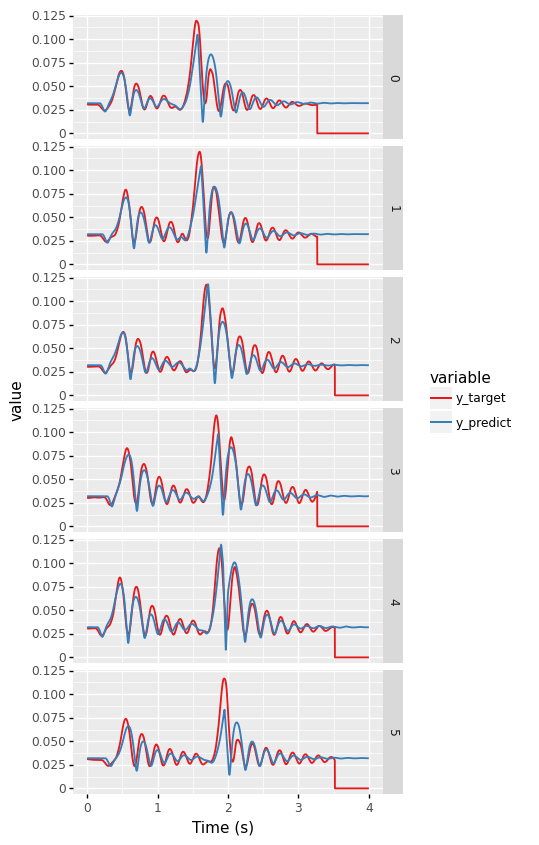

<ggplot: (8750221815507)>

In [155]:
p = ggplot(aes(x='y_time', y='value', color='variable'), dfm)
p = (
    p
    + geom_line(size=0.75) 
    + facet_grid('sample ~ .')
    + xlim(0, 4) 
    + theme(figure_size=(4, 4), aspect_ratio=0.4) 
    + scale_color_brewer(type='qual', palette=6)
    + xlab('Time (s)')
)
p

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 5875 rows containing missing values.


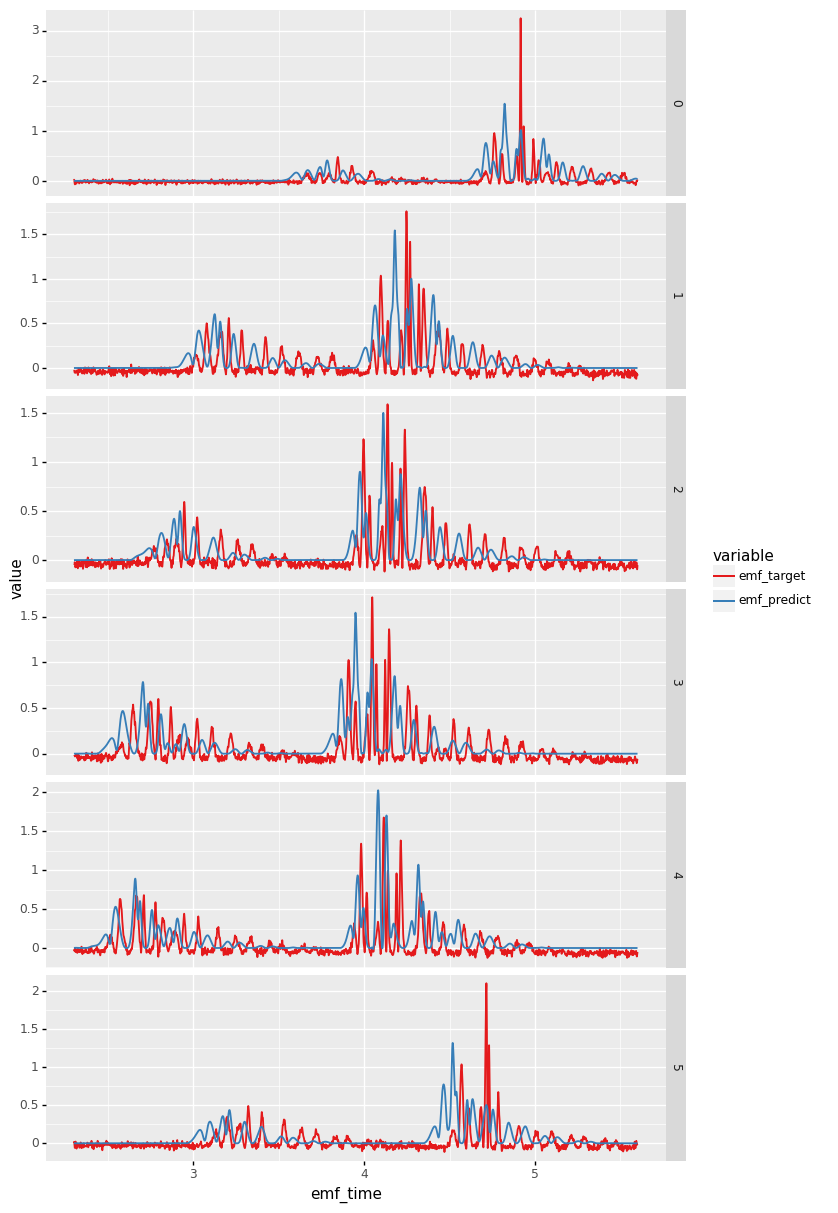

<ggplot: (-9223363286654506464)>

In [154]:
p = ggplot(aes(x='emf_time', y='value', color='variable'), dfe)
p = (
    p
    + geom_line(size=0.75) 
    + facet_grid('sample ~ .', scales='free_y')
    + xlim(2.3, 5.6) 
    + theme(figure_size=(8, 8), aspect_ratio=0.3) 
    + scale_color_brewer(type='qual', palette=6)
)
p

('../data/2021-03-05/D/log_02_acc.csv', '../data/2021-03-05/D/log_02_adc.csv', '../data/2021-03-05/D/d002_transcoded_subsampled_labels_2021-03-07-10:45:31.csv')
{'dtw_distance': 6.693154021216377} {'rms_perc_diff': 11.879369000599791, 'rms': (0.26046562348599395, 0.2328093426095365), 'dtw_distance': 148.4146257641306}


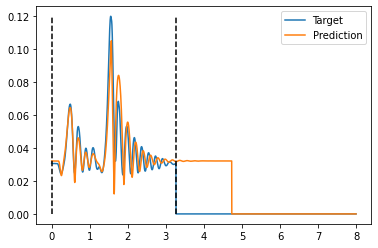

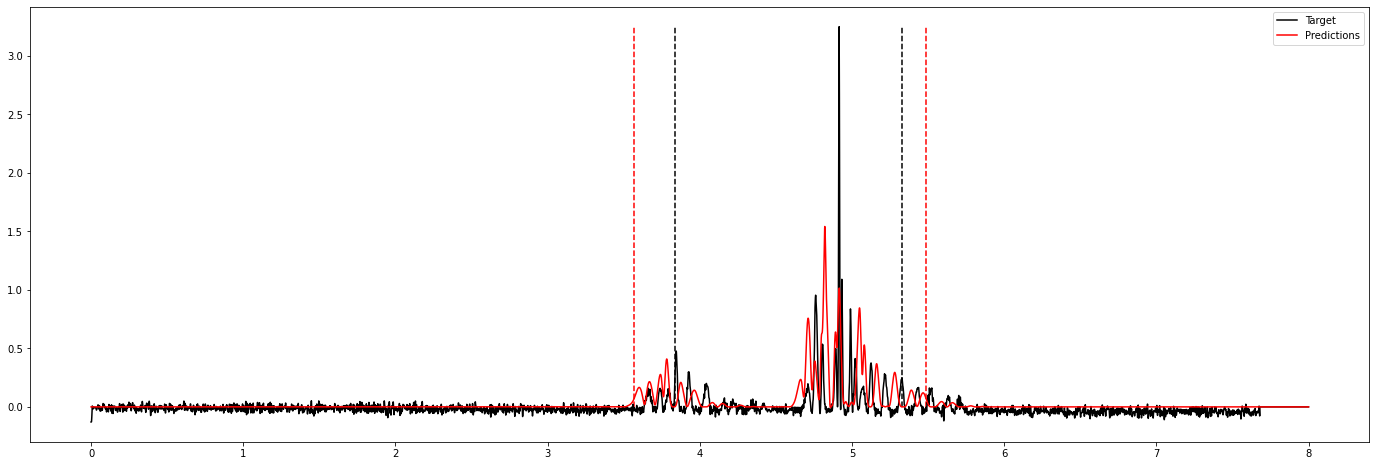

In [25]:
which = 0
print(samples_list[which].paths)
run(input_excitations[which], groundtruth[which], unified_model)